### Linear Regression and Clustering

In [69]:
%pylab inline
import numpy as np
from sklearn import neighbors
from numpy import genfromtxt
import scipy.spatial.distance as dist
import random
from sklearn.cluster import KMeans
from PIL import Image
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Model selection for linear regression using Ordinary Least Squares, Ridge Regression and the LASSO.

The dataset has 8 features:

    lcavol - log cancer volume
    lcaweight - log prostate weight
    age
    lbph - log of amount of benign prostatic hyperplasia
    svi - seminal vesicle invasion
    lcp - log capsular penetration
    gleason - Gleason score
    pgg45 - percent of Gleason scores 4 or 5

I predicted the level of a prostate-specific antigen. The data set was collected from a set of men about to receive a radical prostatectomy.

In [116]:
# Load the data
trainp= genfromtxt('trainp.csv',delimiter=',')
trainp = np.reshape(trainp,(-1,1))
trainp = np.reshape(trainp,(67,9))

# Training data: 
trainfeat=trainp[:,:-1] #Training features (rows are feature vectors)
trainresp=trainp[:,-1] #Training responses

trainresp = np.reshape(trainresp,(-1,1))
trainfeat = np.reshape(trainfeat,(67,8))

valp= genfromtxt('valp.csv',delimiter=',')
#print(trainp)
valp = np.reshape(valp,(-1,1))
valp = np.reshape(valp,(30,9))
# Validation data:
valfeat=valp[:,:-1] #Validation Features (rows are feature vectors)
valresp=valp[:,-1] #Validation Response

valresp = np.reshape(valresp,(-1,1))
valfeat = np.reshape(valfeat,(30,8))

# Standardize and center the features
ftsclr=StandardScaler()
trainfeat = ftsclr.fit_transform(trainfeat)
valfeat= ftsclr.transform(valfeat)
# and the responses (note that the example in the notes has centered but not 
#                    standardized responses, so your numbers won't match up)
rsclr=StandardScaler()
trainresp = (rsclr.fit_transform(trainresp.reshape(-1,1))).reshape(-1)
valresp= (rsclr.transform(valresp.reshape(-1,1))).reshape(-1)

# The training features are in trainfeat
# The training responses are in trainresp
# The validation features are in valfeat
# The validation responses are in valresp

If another model does worse than this, it is a sign that something is amiss.

Note: The RSS on a data set with $V$ samples is given by $\frac{1}{V} \lVert \mathbf{y} - \hat{\mathbf{y}} \rVert^2$ where $\mathbf{y}$ is a vector of the responses, and $\hat{\mathbf{y}}$ is the predicted responses on the data.

In [298]:

from scipy.spatial.distance import cdist

def validationRSS(responses, predictedResponses):
    
    rss = (1/(responses.shape[0]))*((np.linalg.norm(responses - predictedResponses))**2)
    
    return rss

predictedResponse = np.mean(trainresp)
print(validationRSS(valresp,predictedResponse))    

0.733852091913


[Validation RSS: 0.733852091913]

First, I tried (Ordinary) Least Squares. Use `sklearn.linear_model.LinearRegression` with the default options and calculated the validation RSS.

Note: The .score() method returns an [$R^2$  value](https://en.wikipedia.org/wiki/Coefficient_of_determination), not the RSS, so you shouldn't use it anywhere. 

In [300]:

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(trainfeat, trainresp)
predictedResponse = reg.predict(valfeat)
print(validationRSS(valresp,predictedResponse))

0.362307099038


[Validation RSS: 0.362307099038]

I applied ridge regression with `sklearn.linear_model.Ridge`. 

Sweep the regularization/tuning parameter $\alpha=0,\ldots,100$ with 1000 equally spaced values. 

Make a plot of the RSS on the validation set versus $\alpha$.

Larger values of $\alpha$ shrink the weights in the model more. $\alpha=0$ corresponds to the LS solution. 

Minimizing alpha: 12.3
Corresponding validation error 0.338485373765
Corresponding coeffecients [ 0.58562193  0.24207795 -0.11595171  0.17496579  0.25469929 -0.22971721
 -0.01443392  0.22383412]


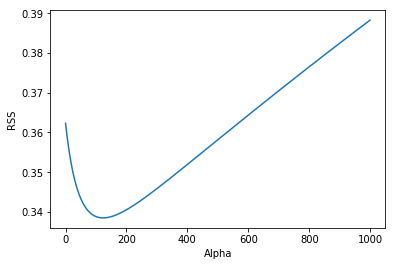

In [319]:

from sklearn.linear_model import Ridge

arr_RSS = []

for i in arange(0, 100, 0.1):
    ridge = Ridge(alpha = i)
    ridge.fit(trainfeat, trainresp)
    predictedResponse = ridge.predict(valfeat)
    #coeff = ridge.coef_
    
    err = validationRSS(valresp, predictedResponse)
    
    arr_RSS.append(err)

min_alpha = np.argmin(arr_RSS)
min_err = arr_RSS[min_alpha]

ridge = Ridge(alpha = min_err)
ridge.fit(trainfeat, trainresp)
predictedResponse = ridge.predict(valfeat)
coeff = ridge.coef_


plt.plot(arr_RSS)
plt.xlabel("Alpha")
plt.ylabel("RSS")

min_alpha *= .1
print ("Minimizing alpha:", min_alpha)
print ("Corresponding validation error", min_err)
print ("Corresponding coeffecients", coeff)

[Minimizing alpha: 12.3
Corresponding validation error 0.338485373765
Corresponding coeffecients [ 0.58562193  0.24207795 -0.11595171  0.17496579  0.25469929 -0.22971721
 -0.01443392  0.22383412]]

Now, I applied the LASSO with `sklearn.linear_model.Lasso`. 

Sweep the tuning/regularization parameter $\alpha=0,\ldots,1$ with 1000 equally spaced values. 

Make a plot of the RSS on the validation set versus $\alpha$. 

Larger values of $\alpha$ lead to sparser solutions (i.e. less features used in the model), with a sufficiently large value of $\alpha$ leading to a constant prediction. Small values of $\alpha$ are closer to the LS solution, with $\alpha=0$ being the LS solution.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/divyam/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/divyam/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Minimizing alpha: 0.093
Corresponding validation error 0.314264916521
Corresponding coeffecients [ 0.40398092  0.04966228  0.          0.          0.          0.          0.
  0.        ]


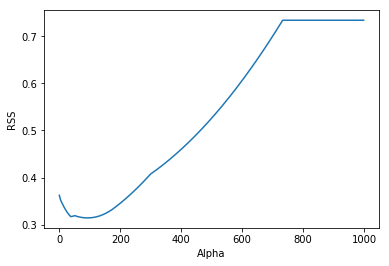

In [320]:
# Put your code here
from sklearn.linear_model import Lasso

arr_RSS = []

for i in arange(0, 1, 0.001):
    lasso = Lasso(alpha = i)
    lasso.fit(trainfeat, trainresp)
    predictedResponse = lasso.predict(valfeat)
    #coeff = lasso.coef_
    
    err = validationRSS(valresp, predictedResponse)
    
    arr_RSS.append(err)

min_alpha = np.argmin(arr_RSS)
min_err = arr_RSS[min_alpha]

lasso = Lasso(alpha = min_err)
lasso.fit(trainfeat, trainresp)
predictedResponse = ridge.predict(valfeat)
coeff = lasso.coef_


plt.plot(arr_RSS)
plt.xlabel("Alpha")
plt.ylabel("RSS")

min_alpha *= .001
print ("Minimizing alpha:", min_alpha)
print ("Corresponding validation error", min_err)
print ("Corresponding coeffecients", coeff)

[Minimizing alpha: 0.093
Corresponding validation error 0.314264916521
Corresponding coeffecients [ 0.40398092  0.04966228  0.          0.          0.          0.          0.
  0.        ]]

[Ridge regression can't zero out coefficients; thus, you either end up including all the coefficients in the model, or none of them. In contrast, the LASSO does both parameter shrinkage and variable selection automatically.

The LASSO makes it easier for the coefficients to be zero and therefore easier to eliminate some of your input variable as not contributing to the output.

There are also some practical considerations. The ridge is a bit easier to implement and faster to compute, which may matter depending on the type of data you have.]

### Selecting the number of clusters

K-means clustering Implementation: 

Input:
* A $(N,d)$ numpy.ndarray of unlabeled data (with each row as a feature vector), data
* A scalar $K$ which indicates the number of clusters
* A scalar representing the number of iterations, niter (this is your stopping criterion/criterion for convergence)

The output will be a tuple consisting of a vector of length N containing which cluster ($0,\ldots,K-1$) a feature vector is in and a $(K,d)$ matrix with the rows containing the cluster centers. 


In [117]:

from scipy.spatial.distance import cdist

def kMeans(data,K,niter):

    # Random means
    centers = data[np.random.choice(data.shape[0],K,replace = False)]
    
    z = np.zeros(data.shape[0])
    
    count = niter
    
    while count != 0:
    
        Y = cdist(data,centers,metric="euclidean")

        for index,distances in enumerate(Y,0):
            minimum = np.argmin(distances)
            z[index] = minimum

        for i in range(0,K):
            flag = z==i
            subset = data[flag]
            centers[i] = np.mean(subset,axis=0)
            
        count -= 1    
         
    # Return tuple
    return z,centers

        

            

The K-means clustering problem tries to minimize the following quantity by selecting $\{z_i\}_{i=1}^N$ and $\{\mu_k\}_{k=1}^K$:
$$J_K(\{z_i\}_{i=1}^N ,\{\mu_k\}_{k=1}^K)=\sum_{i=1}^N \lVert \mathbf{x}_i - \mathbf{\mu}_{z_i} \rVert^2$$
where $\mathbf{\mu}_{z_i}$ is the center of the cluster to which $\mathbf{x}_i$ is assigned.

One visual heuristic to choose the number of clusters from the data (where the number of clusters is not known a priori) is to estimate the optimal value of $J_K(\{z_i\}_{i=1}^N ,\{\mu_k\}_{k=1}^K)$, $J^*(K)$ , for different values of $K$ and look for an "elbow" or "knee" in the curve of $J^*$ versus $K$ and choose that value of $K$. 

I ran $K$-means 100 times for each $K=2,\ldots,10$ and calculate $J_K(\{z_i\}_{i=1}^N ,\{\mu_k\}_{k=1}^K)$ for the clustering given by $K$-means. 

* See Tibshirani, Robert, Guenther Walther, and Trevor Hastie. "Estimating the number of clusters in a data set via the gap statistic." Journal of the Royal Statistical Society: Series B (Statistical Methodology) 63.2 (2001): 411-423. Sometimes, an elbow does not exist in the curve or there are multiple elbows or the $K$ value of an elbow cannot be unambiguously identified. Further material can be found on <a href="http://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method">Wikipedia</a> as well.  


In [27]:
# Load up some data, which we will store in a variable called problem1
problem1= genfromtxt('problem1.csv', delimiter=',')

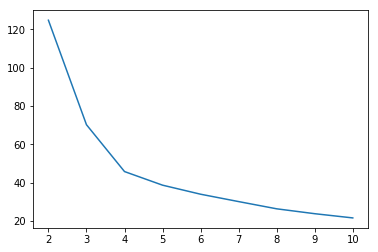

In [78]:

import matplotlib.pyplot as plt

jk = np.zeros((9,2))
#jk = []
for i in range(0, 9):
    
    min = 100000
    
    for k in range(0, 100):
    
        z, centers = kMeans(problem1, i + 2, 100)
        temp_holder = 0
        counter = [0, 0]
        for j in range(0, problem1.shape[0]):
            temp = int(z[j])
            comp_arr = problem1[j] - centers[temp]
            counter += ((np.linalg.norm(comp_arr)))**2
            
        if (counter[0] < min):
            jk[i] = counter[0]
            min = counter[0]

k = np.arange(2,11)    
plt.plot(k, jk[:,0])        

[K = 4 should be picked from this heuristic, since the first knee-point is observed for 3 clusters]

Using the value of $K$ determined from the elbow, I performed K-means clustering on the data. 
Plot it as a scatter plot with the colors given by the labels. 

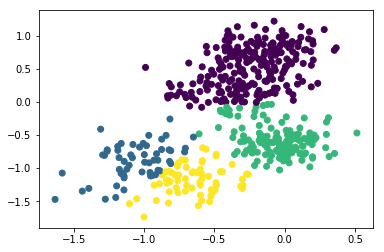

In [73]:
z,centers = kMeans(problem1, 4, 100)
scatter(problem1[:,0], problem1[:,1],c=z)

[J*(K) decreases as K increases. But if we pick a larger K such that J*(K) is minimized, we might split one true cluster into multiple smaller clusters, which is not not ideal.]

### Vector Quantization 

I implemented a vector quantization using `sklearn.cluster.KMeans` for the K-means implementation and using k-means++ as the initialization method. 

Inputs:
* A $(N,M)$ numpy.ndarray representing a greyscale image, called image. (If we want to generate our codebook from multiple images, we can concatenate the images before running them through this function).
* A scalar $B$, for which you will use $B \times B$ blocks for vector quantization. You may assume $N$ and $M$ are divisible by $B$.
* A scalar $K$, which is the size of your codebook

Outputs:
* The codebook as a $(K,B^2)$ numpy.ndarray. 

In [124]:
def trainVQ(image,B,K):
    #Put your code here
    
    nblocks = int (((image.shape[0] * image.shape[1]) / (B**2)))

    #column_reshape = int (((image.shape[0] * image.shape[1]) / (B)))
    
    data = image

    reshaped_blocks = np.zeros((nblocks, B*B))

    blockshaped_arr = blockshaped(data, B, B)
    
    for i in range(0, len(blockshaped_arr)):
        reshaped_blocks[i] = blockshaped_arr[i].flatten()
           

    kmeans = KMeans(n_clusters=K, random_state=0).fit(reshaped_blocks)
    
    centers = kmeans.cluster_centers_
    
    return centers

# https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

    
    

I Wrote a function which compresses an image against a given codebook. 

Inputs:
* A $(N,M)$ numpy.ndarray representing a greyscale image, called image. You may assume $N$ and $M$ are divisible by $B$.
* A $(K,B^2)$ codebook called codebook
* $B$

Outputs:
* A $(N/B,M/B)$ numpy.ndarray consisting of the indices in the codebook used to approximate the image. 


In [125]:
from scipy.spatial.distance import cdist

def compressImg(image,codebook,B):
    
    nblocks = int (((image.shape[0] * image.shape[1]) / (B**2)))
    
    data = image

    reshaped_blocks = np.zeros((nblocks, B*B))

    blockshaped_arr = blockshaped(data, B, B)
    
    l = np.zeros((nblocks, 1))
    
    for i in range(0, len(blockshaped_arr)):
        reshaped_blocks[i] = blockshaped_arr[i].flatten()
        
    Y = cdist(reshaped_blocks,codebook,metric="euclidean")
        
    for index,distances in enumerate(Y,0):
        minimum = np.argmin(distances)
        l[index] = minimum
    
    l = np.reshape(l, (int(image.shape[0]/B), int(image.shape[1]/B)))
    fin_arr = np.zeros((int(image.shape[0]/B), int(image.shape[1]/B)))
    for i in range(0, fin_arr.shape[0]):
        fin_arr[i] = l[i]
        
    return fin_arr 
       
        
        
    

Function to reconstruct an image from its codebook. 

Inputs:
* A $(N/B,M/B)$ numpy.ndarray containing the indices of the codebook for each block called indices
* A codebook as a $(K,B^2)$ numpy.ndarray called codebook
* $B$

Outputs:
A $(N,M)$ numpy.ndarray representing the image. 

In [289]:
def decompressImg(indices, codebook,B):
    #Put your code here
    
    fin_arr = np.zeros((int(indices.shape[0]*B), int(indices.shape[1]*B)))
    
    for i in range(0,indices.shape[0]):
        for j in range(0, indices.shape[1]):
            
            mean = codebook[int(indices[i][j])]
            mean = np.reshape(mean, (B, B))
            # Unravel
            for x in range(0,B):
                for y in range(0,B):
                    fin_arr[x + (i * B),y + (j * B)] = mean[x, y]
    return fin_arr                
           

I rann the vector quantizer with $5 \times 5$ blocks on the provided image with codebook sizes $K=2,5,10,20,50,100,200$ (i.e. generate codebooks from this image of those sizes, compress the image using those codebooks and reconstruct the images). 

The image used is under fair use from [FIFA](https://www.fifa.com/worldcup/news/france-revel-winning-second-world-title-2986453).

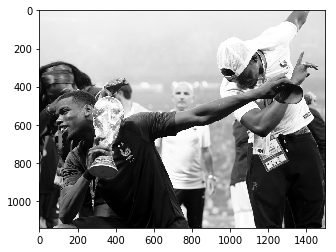

In [268]:
# The provided image is stored in image
image = np.asarray(Image.open("mrtb.jpg").convert("L"))
imshow(image, cmap = cm.Greys_r)

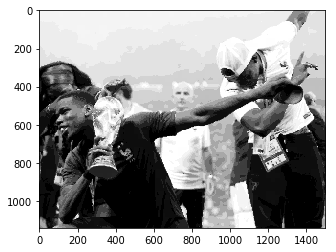

In [331]:


import matplotlib.pyplot as plt

codebook_sizes = [2, 5, 10, 20, 50, 100, 200]

for i in range(0, len(codebook_sizes)):
    
    codebook = trainVQ(image,5,codebook_sizes[i])

    image_compressed = compressImg(image,codebook,5)
    #plt.imshow(image_compressed, cmap = cm.Greys_r)

    image_decompressed = decompressImg(image_compressed, codebook,5)
    #imshow(image_decompressed, cmap = cm.Greys_r)

    #plt.subplot(2,4, i+1)
    plt.imshow(image_decompressed, cmap = cm.Greys_r)
       

[I would pick my codebook based on the most effective quantized binary representation. For example, if I pick k = 10 (qualitatively), I need roughly 26575 bits (~ .133 bits per pixel) to represent the image, which is about 25 B. As k increases, the memory requirement increases and computation power required increases exponentially.]

### Using K-means to Accelerate Nearest Neighbors 

In this problem, I used K-means clustering to accelerate nearest neighbors and used `sklearn.neighbors.KNeighborsClassifier` for nearest neighbor classification and `sklearn.cluster.KMeans` for the K-means implementation with k-means++ as the initialization method.

Function to generate prototypes from labeled data. 

Input:
* Training features as $(N,d)$ numpy.ndarray called traindata
* Training labels as a length $N$ vector called trainlabels
* $K$, the number of prototypes under each class

Output Tuple:
* The prototypes selected as a $(K*\text{number of classes},d)$ numpy.ndarray
* The corresponding labels as a $K*\text{number of classes}$ length vector 

You may assume there are at least $K$ examples under each class. `set(trainlabels)` will give you the set of labels. 

In [189]:
def generatePrototypes(traindata,trainlabels,K):
    # Put your code here
    t_star = []
    lbls = set(trainlabels)
    for k in range(0, len(lbls)):
        
        flag = trainlabels==k
        
        trainsubset = traindata[flag]
        
        kmeans = KMeans(n_clusters=K, random_state=0).fit(trainsubset)
        
        centers = kmeans.cluster_centers_

        t_star.append(centers)
        
    returnProto =[]
    for c in t_star:
        for j in c:
            returnProto.append(j)
            
    labelret = []        
    for i in range(0,len(lbls)):
        for k in range(0,K):
            labelret.append(i)
            
    return (returnProto,labelret ) 
            

Trained a nearest neighbor classifier (i.e. 1-NN)  with 1,10,50,100 and 200 prototypes per class for the digits data set.

In [177]:
# Load the digits data set

#Read in the Training Data
traindata_tmp= genfromtxt('zip.train', delimiter=' ')
#The training labels are stored in "trainlabels", training features in "traindata"
trainlabels=traindata_tmp[:,0]
traindata=traindata_tmp[:,1:]


#Read in the Validation Data
valdata_tmp= genfromtxt('zip.val', delimiter=' ')
#The validation labels are stored in "vallabels", validation features in "valdata"
vallabels=valdata_tmp[:,0]
valdata=valdata_tmp[:,1:]


In [188]:

from sklearn.neighbors import KNeighborsClassifier

proto,labels = generatePrototypes(traindata,trainlabels,1)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(proto, labels) 
%timeit neigh.fit(proto, labels)
val_error = (1 - neigh.score(valdata, vallabels))
print("1 prototype error:",val_error)

proto,labels = generatePrototypes(traindata,trainlabels,10)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(proto, labels) 
%timeit neigh.fit(proto, labels)
val_error = (1 - neigh.score(valdata, vallabels))
print("10 prototype error:",val_error)

proto,labels = generatePrototypes(traindata,trainlabels,50)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(proto, labels) 
%timeit neigh.fit(proto, labels)
val_error = (1 - neigh.score(valdata, vallabels))
print("50 prototype error:",val_error)

proto,labels = generatePrototypes(traindata,trainlabels,100)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(proto, labels) 
%timeit neigh.fit(proto, labels)
val_error = (1 - neigh.score(valdata, vallabels))
print("100 prototype error:",val_error)

proto,labels = generatePrototypes(traindata,trainlabels,200)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(proto, labels) 
%timeit neigh.fit(proto, labels)
val_error = (1 - neigh.score(valdata, vallabels))
print("200 prototype error:",val_error)

222 µs ± 35.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1 prototype error: 0.185849526657
349 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
10 prototype error: 0.0807174887892
1.99 ms ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
50 prototype error: 0.0687593423019
4.99 ms ± 85.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
100 prototype error: 0.0548081714001
11.9 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
200 prototype error: 0.0553064275037


[The validation error for more than 100 prototypes is less than the validation error for the nearest neighbour classifier. The LDA has a much higher validation error, though it is computationally effecient. I would pick a 100 prototypes per class because it has a runtime of aaround 5 ms and a pretty low validation error.]